# Data Check-in


In [1]:
from nilearn import datasets,image,masking,signal,plotting,input_data
import numpy as np
import pandas as pd
import sklearn as skl
import os
import matplotlib.pyplot as plt
import re

# Pauli subcortical atlas
subcortex = datasets.fetch_atlas_pauli_2017()
ho=datasets.fetch_atlas_harvard_oxford('cort-prob-1mm')

print(ho.labels.index('Frontal Medial Cortex'))

func_eg='sub-1001/L2_task-MID_model-01_type-act_sm-6.gfeat/cope1.feat/stats/cope1.nii.gz'
mean_img=image.image.mean_img(func_eg)

data=[['sub-1001',5],['sub-1002',2],['sub-1003',5],['sub-1004',3],['sub-1006',3]]
group_data=pd.DataFrame(data=data,columns=['sub_number','Rew_sens'])
group_data
analysis_dir='/data/projects/istart-analyses/derivatives/fsl_task-sharedreward'

/usr/local/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Python2 support is deprecated and will be removed in a future release. Consider switching to Python3.
  """Entry point for launching an IPython kernel.
/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/utils/graph.py:15: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .graph_shortest_path import graph_shortest_path  # noqa
/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/base.py:35: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ..utils.seq_da

25


['Pu', 'Ca', 'NAC', 'EXA', 'GPe', 'GPi', 'SNc', 'RN', 'SNr', 'PBP', 'VTA', 'VeP', 'HN', 'HTH', 'MN', 'STH']


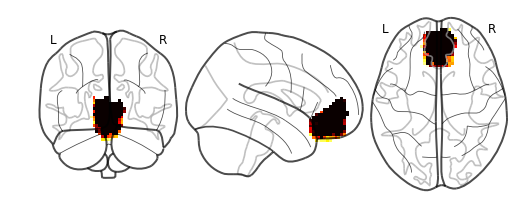

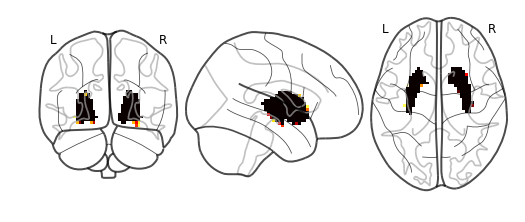

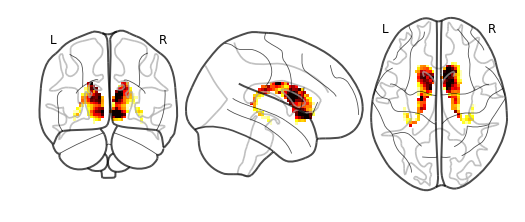

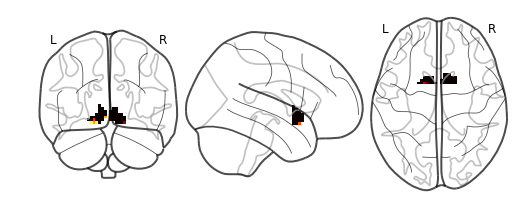

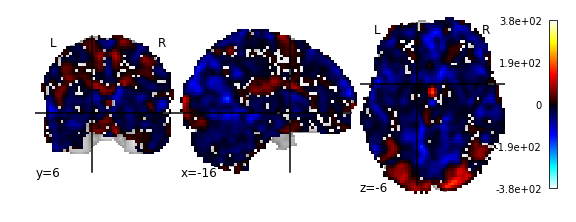

In [2]:

print(subcortex.labels)

res_mpfc=masking.compute_background_mask(
    image.resample_to_img(image.index_img(ho.maps,24),mean_img,interpolation='linear'))

res_put=masking.compute_background_mask(
    image.resample_to_img(image.index_img(subcortex.maps,0),mean_img,interpolation='linear'))

res_caud=masking.compute_background_mask(
    image.resample_to_img(image.index_img(subcortex.maps,1),mean_img,interpolation='linear'))

res_Nac=masking.compute_background_mask(
    image.resample_to_img(image.index_img(subcortex.maps,2),mean_img,interpolation='linear'))

#make a few different maskers for full subcortex of interest and sub areas
mPFC_masker=input_data.NiftiMasker(mask_img=res_mpfc,standardize=False)
Put_masker=input_data.NiftiMasker(mask_img=res_put,standardize=False)                                  
Caud_masker=input_data.NiftiMasker(mask_img=res_caud,standardize=False)                        
NAc_masker=input_data.NiftiMasker(mask_img=res_Nac,standardize=False)

maskers=[Put_masker,Caud_masker,NAc_masker,mPFC_masker]

#look at all the masked images they make
Put_masked_img=Put_masker.fit_transform(func_eg)
Caud_masked_img=Caud_masker.fit_transform(func_eg)
NAc_masked_img=NAc_masker.fit_transform(func_eg)
mPFC_masked=mPFC_masker.fit_transform(func_eg)

plotting.plot_glass_brain(image.image.mean_img(
        mPFC_masker.inverse_transform(mPFC_masked)))
plotting.plot_glass_brain(image.image.mean_img(
        Put_masker.inverse_transform(Put_masked_img)))
plotting.plot_glass_brain(image.image.mean_img(
        Caud_masker.inverse_transform(Caud_masked_img)))
plotting.plot_glass_brain(image.image.mean_img(
        NAc_masker.inverse_transform(NAc_masked_img)))
plotting.plot_stat_map(func_eg,threshold=3.1,cut_coords=(-16,6,-6))
plt.show()

In [17]:
np.mean(NAc_masked_img)
func_list=[]
os.chdir(analysis_dir)
sub_dirs=[d for d in os.listdir(analysis_dir) if d.startswith('sub-')]
for sd in sub_dirs:
    for root,dirs,files in os.walk(analysis_dir+'/'+sd):
        for d in dirs:
             if ('L1_task-' in d) and ('+' not in d):
                func_list.append([os.path.join(sd,d,'stats',f) for f in os.listdir(
                    os.path.join(root,d,'stats')) if 'cope' in f])

func_list=np.concatenate(func_list)
wanted_files=('cope1.nii.gz','cope2.nii.gz','cope3.nii.gz','cope4.nii.gz','cope5.nii.gz',
              'cope6.nii.gz','cope7.nii.gz','cope8.nii.gz','cope9.nii.gz','cope10.nii.gz',
              'cope11.nii.gz','cope12.nii.gz')
func_list=[f for f in func_list if f.split('/')[-1] in wanted_files ]
func_list=[f for f in func_list if 'stats/cope' in f]


32

In [35]:
values=['sub_number','Activity','Area','Que']
data=[]
for f in func_list:
    sub="sub-"+re.search('sub-(.*)/L1_task',f).group(1)
    if f.find('cope7.nii')!=-1:
        que='All_rew-pun'
    elif f.find('cope1.nii')!=-1:
        que='Comp_Rew'
    elif f.find('cope2.nii')!=-1:
        que='Comp_Pun'
    else:
        continue
    NAc_act=np.mean(NAc_masker.fit_transform(f))
    Put_act=np.mean(Put_masker.fit_transform(f))
    Caud_act=np.mean(Caud_masker.fit_transform(f))
    mPFC_act=np.mean(mPFC_masker.fit_transform(f))
    
    row1=[sub,NAc_act,"nAcc",que]
    row2=[sub,Put_act,"Put",que]
    row3=[sub,Caud_act,"Caudate",que]
    row4=[sub,mPFC_act,"mPFC",que]
    data.append(row1)
    data.append(row2)
    data.append(row3)
    data.append(row4)

df=pd.DataFrame(data=data,columns=values)  
display(df.head())

,sub_number,Activity,Area,Que
0,sub-1003,3.656634,nAcc,All_rew-pun
1,sub-1003,29.009834,Put,All_rew-pun
2,sub-1003,63.704620,Caudate,All_rew-pun
3,sub-1003,-79.425713,mPFC,All_rew-pun
4,sub-1003,23.428598,nAcc,Comp_Rew


In [40]:
plot_data['sub_number']

0     sub-1003
1     sub-1003
2     sub-1003
3     sub-1002
4     sub-1002
5     sub-1002
6     sub-1004
7     sub-1004
8     sub-1004
9     sub-1004
10    sub-1004
11    sub-1004
12    sub-1001
13    sub-1001
14    sub-1001
15    sub-1001
16    sub-1001
17    sub-1001
18    sub-1006
19    sub-1006
20    sub-1006
21    sub-1006
22    sub-1006
23    sub-1006
Name: sub_number, dtype: object

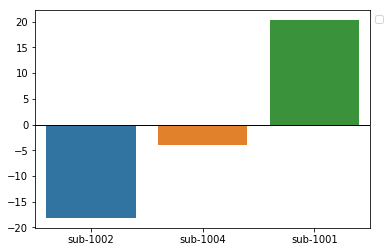

In [57]:
import seaborn as sns
area='nAcc'
contrast=['All_rew-pun']
title="area-%s_contrasts-%s"%(area,contrast[0])
df1=df[df['Area']==area]
plot_data=pd.merge(df1,group_data,on='sub_number')
plot_data=plot_data.groupby(['sub_number','Que','Rew_sens'])['Activity'].mean().reset_index()

plot_data=plot_data[~plot_data['sub_number'].isin(['sub-1003','sub-1006'])]

e=sns.barplot(x="sub_number",y="Activity",data=plot_data[plot_data["Que"].isin(contrast)],
              ci=None,order=['sub-1002','sub-1004','sub-1001'])
e.set(xlabel='',ylabel='')

e=e.get_figure()
plt.legend(bbox_to_anchor=(1.00,1) ,loc=2)
plt.plot([-0.50,6],[0,0],'k-',linewidth=1)

plt.show()

e.savefig("figures/%s.svg"%(title),dpi=300)


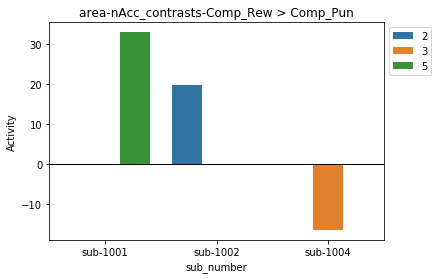

In [52]:
area='nAcc'
top='Comp_Rew'
bottom='Comp_Pun'
contrast=["%s > %s"%(top,bottom)]
title="area-%s_contrasts-%s"%(area,contrast[0])


data=[]
for sub in df.sub_number.unique():
    df_LR=df[(df['sub_number']==sub) & (df['Que']==top) & (df['Area']==area)]
    df_N=df[(df['sub_number']==sub) & (df['Que']==bottom) & (df['Area']==area)]
    np.subtract(df_LR.Activity.iloc[0],df_N.Activity.iloc[0])
    data.append([sub,contrast[0],np.subtract(df_LR.Activity.iloc[0],df_N.Activity.iloc[0])])
data=pd.DataFrame(data=data,columns=['sub_number','Que','Activity'])
#plot_data=pd.merge(data,group_data,on='sub_number')

plot_data=plot_data[~plot_data['sub_number'].isin(['sub-1003','sub-1006'])]
plot_data=plot_data.groupby(['sub_number','Que','Rew_sens'])['Activity'].mean().reset_index()

e=sns.barplot(x="sub_number",y="Activity",data=plot_data[plot_data["Que"].isin(contrast)],
                hue='Rew_sens',dodge=True).set_title(title)
e=e.get_figure()
plt.legend(bbox_to_anchor=(1.00,1) ,loc=2)
plt.plot([-0.50,6],[0,0],'k-',linewidth=1)

plt.show()
e.savefig("figures/%s.pdf"%(title),dpi=300)


In [54]:
data

,sub_number,Que,Activity
0,sub-1003,Comp_Rew > Comp_Pun,34.946774
1,sub-1002,Comp_Rew > Comp_Pun,19.836578
2,sub-1004,Comp_Rew > Comp_Pun,-16.569381
3,sub-1001,Comp_Rew > Comp_Pun,32.923207
4,sub-1006,Comp_Rew > Comp_Pun,-49.215084


In [ ]:
df_LR.Activity.iloc[0]